# Document Embedding with Word2Vec

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil

## Dataset
This code downloads a [dataset](http://mlg.ucd.ie/datasets/bbc.html) consisting of several BBC news articles belonging to various categories (e.g. sport, politics, etc.). Additionally the code makes sure the file has the correct size after downloading it.

In [4]:
url = 'http://mlg.ucd.ie/files/datasets/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('bbc-fulltext.zip', 2874078)

Found and verified bbc-fulltext.zip


## Read Data with Preprocessing with NLTK
Reads data as it is to a string, convert to lower-case and tokenize it using the nltk library. We have two functions `read_data` which reads `files_to_read_for_topic` files from each category and `read_test_data` which set aside 10 documents from the read documents for testing purposes.

In [6]:
def read_data(filename):
  """
  Extract articles up to a given threshold in a zip file as a list of words
  and pre-processes it using the nltk python library
  """
  data = []
  files_to_read_for_topic = 250
  topics = ['business','entertainment','politics','sport','tech']
  with zipfile.ZipFile(filename) as z:
    parent_dir = z.namelist()[0]
    for t in topics:
        print('\tFinished reading data for topic: ',t)
        for fi in range(1,files_to_read_for_topic):
            with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                file_string = f.read().decode('latin-1')
                file_string = file_string.lower()
                file_string = nltk.word_tokenize(file_string)
                data.extend(file_string)
                
    return data

def read_test_data(filename):
  """
  Extract articles up to a given threshold in a zip file as a list of words
  and pre-processes it using the nltk python library
  """
  test_data = {}
  files_to_read_for_topic = 250
  topics = ['business','entertainment','politics','sport','tech']
  with zipfile.ZipFile(filename) as z:
    parent_dir = z.namelist()[0]
    for t in topics:
        print('\tFinished reading data for topic: ',t)
            
        for fi in np.random.randint(1,files_to_read_for_topic,(10)).tolist():
            with z.open(parent_dir + t + '/'+ format(fi,'03d')+'.txt') as f:
                file_string = f.read().decode('latin-1')
                file_string = file_string.lower()
                file_string = nltk.word_tokenize(file_string)
                test_data[t+'-'+str(fi)] = file_string
                
    return test_data

print('Processing training data...')
words = read_data(filename)
print('\nProcessing testing data...')
test_words = read_test_data(filename)

print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Processing training data...
	Finished reading data for topic:  business
	Finished reading data for topic:  entertainment
	Finished reading data for topic:  politics
	Finished reading data for topic:  sport
	Finished reading data for topic:  tech

Processing testing data...
	Finished reading data for topic:  business
	Finished reading data for topic:  entertainment
	Finished reading data for topic:  politics
	Finished reading data for topic:  sport
	Finished reading data for topic:  tech
Example words (start):  ['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us']
Example words (end):  ['almost', '200,000', 'people', 'are', 'registered', 'players', 'on', 'project', 'entropia', '.']


## Building the Dictionaries
Builds the following. To understand each of these elements, let us also assume the text "I like to go to school"

* `dictionary`: maps a string word to an ID (e.g. {I:0, like:1, to:2, go:3, school:4})
* `reverse_dictionary`: maps an ID to a string word (e.g. {0:I, 1:like, 2:to, 3:go, 4:school}
* `count`: List of list of (word, frequency) elements (e.g. [(I,1),(like,1),(to,2),(go,1),(school,1)]
* `data` : Contain the string of text we read, where string words are replaced with word IDs (e.g. [0, 1, 2, 3, 2, 4])

It also introduces an additional special token `UNK` to denote rare words to are too rare to make use of.

In [7]:
vocabulary_size = 25000

def build_dataset(words):
  # Allocate a special token for rare words
  count = [['UNK', -1]]

  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))


  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
    
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
    
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size

  return data, count, dictionary, reverse_dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    '''
    Here we use this function to convert word strings to IDs
    with a given dictionary
    '''
    data = list()
    for word in words:
        if word in dictionary:
          index = dictionary[word]
        else:
          index = 0  # dictionary['UNK']
        data.append(index)
    return data

# Processining training data
data, count, dictionary, reverse_dictionary = build_dataset(words)

# Processing test data
test_data = {}
for k,v in test_words.items():
    print('Building Test Dataset for ',k,' topic')
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)
    
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('test keys: ',test_data.keys())
del words  # Hint to reduce memory.
del test_words

Building Test Dataset for  business-224  topic
Building Test Dataset for  business-156  topic
Building Test Dataset for  business-97  topic
Building Test Dataset for  business-54  topic
Building Test Dataset for  business-236  topic
Building Test Dataset for  business-30  topic
Building Test Dataset for  business-154  topic
Building Test Dataset for  business-170  topic
Building Test Dataset for  business-233  topic
Building Test Dataset for  business-141  topic
Building Test Dataset for  entertainment-26  topic
Building Test Dataset for  entertainment-34  topic
Building Test Dataset for  entertainment-214  topic
Building Test Dataset for  entertainment-152  topic
Building Test Dataset for  entertainment-191  topic
Building Test Dataset for  entertainment-145  topic
Building Test Dataset for  entertainment-80  topic
Building Test Dataset for  entertainment-249  topic
Building Test Dataset for  entertainment-58  topic
Building Test Dataset for  entertainment-209  topic
Building Test Dat

## Generating Batches of Data for Skip-Gram
Generates a batch or target words (`batch`) and a batch of corresponding context words (`labels`). It reads `2*window_size+1` words at a time (called a `span`) and create `2*window_size` datapoints in a single span. The function continue in this manner until `batch_size` datapoints are created. Everytime we reach the end of the word sequence, we start from beginning. 

In [8]:
data_index = 0

def generate_batch(data, batch_size, window_size):
    # data_index is updated by 1 everytime we read a data point
    global data_index
    
    # span defines the total window size, where
    # data we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    span = 2 * window_size + 1
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # This is the number of context words we sample for a single target word
    num_samples = 2*window_size 

    # We break the batch reading into two for loops
    # The inner for loop fills in the batch and labels with 
    # num_samples data points using data contained withing the span
    # The outper for loop repeat this for batch_size//num_samples times
    # to produce a full batch
    for i in range(batch_size // num_samples):
      k=0
      # avoid the target word itself as a prediction
      # fill in batch and label numpy arrays
      for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
        batch[i * num_samples + k] = buffer[window_size]
        labels[i * num_samples + k, 0] = buffer[j]
        k += 1 
    
      # Everytime we read num_samples data points,
      # we have created the maximum number of datapoints possible
      # withing a single span, so we need to move the span by 1
      # to create a fresh new span
      buffer.append(data[data_index])
      data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch(data, batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with window_size = 1:
    batch: [['sales', 'sales'], ['sales', 'sales'], ['boost', 'boost'], ['boost', 'boost'], ['time', 'time'], ['time', 'time'], ['warner', 'warner'], ['warner', 'warner']]
    labels: ['ad', 'boost', 'sales', 'time', 'boost', 'warner', 'time', 'profit']

with window_size = 2:
    batch: [['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['boost', 'boost', 'boost', 'boost'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time'], ['time', 'time', 'time', 'time']]
    labels: ['ad', 'sales', 'time', 'warner', 'sales', 'boost', 'warner', 'profit']


In [9]:
test_data_index = 0

def generate_test_batch(data, batch_size):
    '''
    Generate a batch of data from the test data
    This is used to compute the document embedding
    by taking the average of all the words in a document
    '''
    global test_data_index

    batch = np.ndarray(shape=(batch_size,), dtype=np.int32)
    # Get words starting from index 0 to span
    for bi in range(batch_size):
        batch[bi] = data[test_data_index]
        test_data_index = (test_data_index + 1) % len(data)

    return batch

test_data_index = 0
test_batch = generate_test_batch(test_data[list(test_data.keys())[0]], batch_size=8)
print('\nwith window_size = %d:' % (window_size))
print('    labels:', [reverse_dictionary[li] for li in test_batch.reshape(8)])


with window_size = 2:
    labels: ['man', 'utd', 'to', 'open', 'books', 'to', 'glazer', 'manchester']


# CBOW Algorithm

### Defining Hyperparameters

Here we define several hyperparameters including `batch_size` (amount of samples in a single batch) `embedding_size` (size of embedding vectors) `window_size` (context window size).

In [10]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

### Defining Inputs and Outputs

Here we define placeholders for feeding in training inputs and outputs (each of size `batch_size`) and a constant tensor to contain validation examples.

In [11]:
tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])

# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data used to evaluate the word vectors
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Test data. This is used to compute the document embeddings by averaging
# word embeddings of a given document
test_labels = tf.placeholder(tf.int32, shape=[batch_size],name='test_dataset')

### Defining Model Parameters and Other Variables
We now define several TensorFlow variables such as an embedding layer (`embeddings`) and neural network parameters (`softmax_weights` and `softmax_biases`)

In [12]:
# Variables.
# embedding, vector for each word in the vocabulary
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size],dtype=tf.float32))

### Defining the Model Computations

We first defing a lookup function to fetch the corresponding embedding vectors for a set of given inputs. With that, we define negative sampling loss function `tf.nn.sampled_softmax_loss` which takes in the embedding vectors and previously defined neural network parameters.

In [13]:
# Used to compute document embeddings by averaging all the word vectors of a 
# given batch of test data
mean_batch_embedding = tf.reduce_mean(tf.nn.embedding_lookup(embeddings,test_labels),axis=0)
    
# Model.
# Look up embeddings for all the context words of the inputs.
# Then compute a tensor by staking embeddings of all context words
stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

# Make sure the staked embeddings have 2*window_size columns
assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())

# Compute mean embeddings by taking the mean of the tensor containing the stack of embeddings
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())


Defining 8 embedding lookups representing each word in the context
Stacked embedding size: [128, 128, 8]
Reduced mean embedding size: [128, 128]


## Computing Loss
Loss computation using sampled softmax

In [14]:
# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings

# If you see the warning
# WARNING:tensorflow:From c:\...\lib\site-packages\tensorflow\python\ops\nn_impl.py:1346: 
# softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and 
# will be removed in a future version.
# You can ignore this. This caused by the internally used softmax_cross_entropy_with_logits function
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

### Calculating Word Similarities 
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below.

In [15]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### Model Parameter Optimizer

We then define a constant learning rate and an optimizer which uses the Adagrad method. Feel free to experiment with other optimizers listed [here](https://www.tensorflow.org/api_guides/python/train).

In [16]:
# Optimizer. Adagrad optimizers has learning rates assigned to individual parameters
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Running the CBOW Algorithm on Document Data

Here we run the CBOW algorithm we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [17]:
num_steps = 100001
cbow_loss = []

config=tf.ConfigProto(allow_soft_placement=True)
# This is an important setting and with limited GPU memory,
# not using this option might lead to the following error.
# InternalError (see above for traceback): Blas GEMM launch failed : ...
config.gpu_options.allow_growth = True

with tf.Session(config=config) as session:
    
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
        
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch(data, batch_size, window_size)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step+1, average_loss))
            cbow_loss.append(average_loss)
            average_loss = 0
        
        # Evaluating validation set word similarities
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Here we compute the top_k closest words for a given validation word
            # in terms of the cosine distance
            # We do this for all the words in the validation set
            # Note: This is an expensive step
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    
    # Computing test documents embeddings by averaging word embeddings
    
    # We take batch_size*num_test_steps words from each document
    # to compute document embeddings
    num_test_steps = 100
    
    # Store document embeddings
    # {document_id:embedding} format
    document_embeddings = {}
    print('Testing Phase (Compute document embeddings)')
    
    # For each test document compute document embeddings
    for k,v in test_data.items():
        print('\tCalculating mean embedding for document ',k,' with ', num_test_steps, ' steps.')
        test_data_index = 0
        topic_mean_batch_embeddings = np.empty((num_test_steps,embedding_size),dtype=np.float32)
        
        # keep averaging mean word embeddings obtained for each step
        for test_step in range(num_test_steps):
            test_batch_labels = generate_test_batch(test_data[k],batch_size)
            batch_mean = session.run(mean_batch_embedding,feed_dict={test_labels:test_batch_labels})
            topic_mean_batch_embeddings[test_step,:] = batch_mean
        document_embeddings[k] = np.mean(topic_mean_batch_embeddings,axis=0)


Initialized
Average loss at step 2000: 3.916321
Average loss at step 4000: 3.566378
Average loss at step 6000: 3.543039
Average loss at step 8000: 3.535968
Average loss at step 10000: 3.469195
Nearest to not: fundraiser, be, prompting, amber, iphigenia, to, rainbow, seasoned,
Nearest to said: krol, told, tempt, angling, 77m, 300m, potato, heroics,
Nearest to he: mr, it, she, i, 120, sandals, anti-terror, purple,
Nearest to more: dictionary, mandatory, debra, unintentional, slim, conceivable, pressure, mcalinden,
Nearest to mr: he, it, penalising, has, investigating, affairs, anti-terror, crammed,
Nearest to -: have, â£35.7m, voice, grumbletext.co.uk, gore, from, and, limb-amputators,
Nearest to 's: told, seedlings, isg, jessica, breakneck, goodison, sympathise, juice,
Nearest to also: stilian, sage, ill-feeling, burchill, mcintosh, mgm, traction, carthy,
Nearest to as: incentives, merges, undoubtedly, wave, 0.9, unveils, inwhich, recognizes,
Nearest to is: zutons, was, hospitality, aud

Average loss at step 68000: 3.084461
Average loss at step 70000: 3.082477
Nearest to not: n't, â£42m, but, they, mutant, that, to, if,
Nearest to said: added, told, says, â£2.4m, :, '', ``, coup,
Nearest to he: mr, she, ``, it, i, the, but, we,
Nearest to more: than, 2:17:18, photonics, there, little, it, preside, argentine,
Nearest to mr: he, '', ukif, mccartney, ms, ``, birthdays, british-born,
Nearest to -: finishes, essential, dbs, ,, and, pcg-x505/p, 'loses, coincide,
Nearest to 's: connectotel, caouette, the, '', on, ,, lake, gillmor,
Nearest to also: that, murderers, tempered, installing, coast, counterterrorism, gidley, greatly,
Nearest to as: well, such, filled, e-economy, described, 2.05, installing, senate,
Nearest to is: are, was, has, would, can, were, will, 0.90,
Nearest to the: a, ., to, 's, ,, '', and, he,
Nearest to a: the, an, reid, reeve, raitt, deselection, aerospace, fed,
Nearest to which: 'ass-saver, responsible, fruit, cumberbatch, changeover, winds, when, edges,

	Calculating mean embedding for document  tech-73  with  100  steps.
	Calculating mean embedding for document  tech-147  with  100  steps.
	Calculating mean embedding for document  tech-40  with  100  steps.
	Calculating mean embedding for document  tech-210  with  100  steps.
	Calculating mean embedding for document  tech-185  with  100  steps.
	Calculating mean embedding for document  tech-84  with  100  steps.


## Visualizing documents with t-SNE

### Defining a t-SNE and fitting data
Here we define a t-SNE with its parameters and fit the learned embeddings to visualize them on a two dimensional surface.

In [18]:
# Number of data points to visualize
num_points = 1000 

# Create a t-SNE object
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE')
# get the T-SNE manifold
doc_ids, doc_embeddings = zip(*document_embeddings.items())
two_d_embeddings = tsne.fit_transform(doc_embeddings)
print('\tDone')

Fitting embeddings to T-SNE
	Done


### Plotting the t-SNE results
After fitting the embeddings to the t-SNE, we can visualize the results with Matplotlib library.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

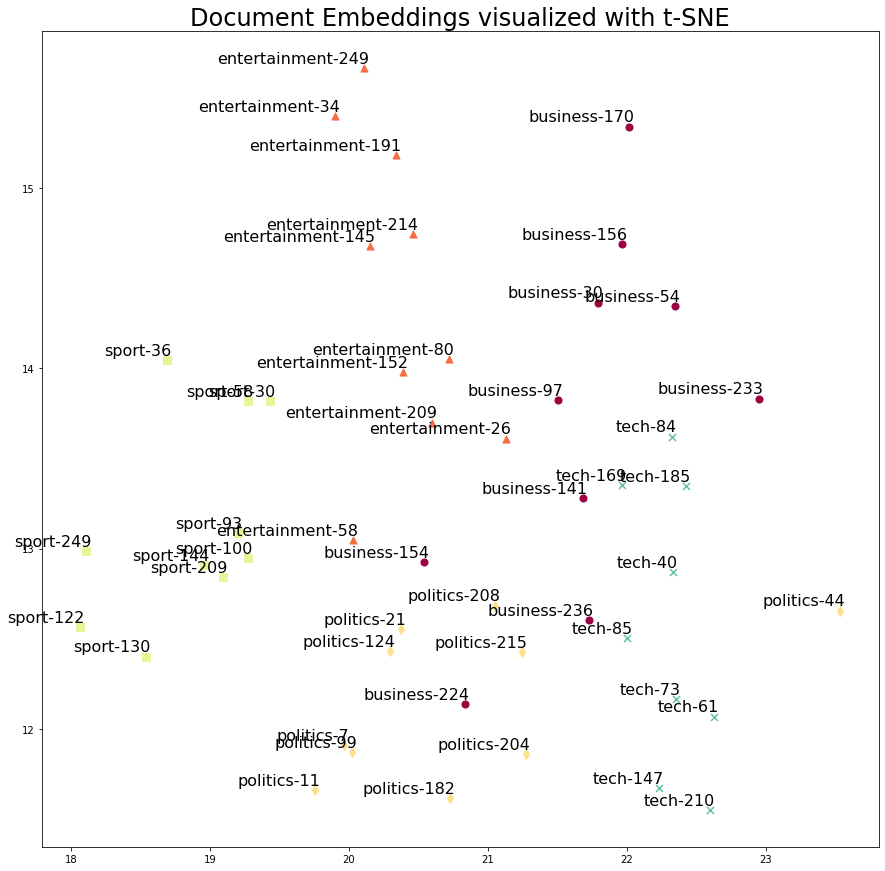

In [19]:
import matplotlib.pyplot as plt
def plot(embeddings, labels):
  
  n_clusters = 5 # number of clusters
    
  # automatically build a discrete set of colors, each for cluster
  label_colors = [plt.cm.Spectral(float(i) /n_clusters) for i in range(n_clusters)]
  label_markers = ['o','^','d','s','x']
  # make sure the number of document embeddings is same as
  # point labels provided
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  
  pylab.figure(figsize=(15,15))  # in inches

  def get_label_id_from_key(key):
    '''
    We assign each different category a cluster_id
    This is assigned based on what is contained in the point label
    Not the actual clustering results
    '''
    if 'business' in key:
        return 0
    elif 'entertainment' in key:
        return 1
    elif 'politics' in key:
        return 2
    elif 'sport' in key:
        return 3
    elif 'tech' in key:
        return 4
            
  # Plot all the document embeddings and their corresponding words
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, c=label_colors[get_label_id_from_key(label)],s=50,
                  marker=label_markers[get_label_id_from_key(label)])    
    
    # Annotate each point on the scatter plot
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)
  
  # Set plot title
  pylab.title('Document Embeddings visualized with t-SNE',fontsize=24)
  
  # Use for saving the figure if needed
  pylab.savefig('document_embeddings.png')
  pylab.show()

# Run the plotting function
plot(two_d_embeddings, doc_ids)

## Perform Document Classification

Here we first cluster the document embeddings by means of K-means. K-means is a popular and simple clustering algorithm. Then we will list what is contained in each cluster. Each cluster should roughly contain documents belonging to a single category. You can use the same information to classify an unseen document using the following steps.
1. Compute the document embeddings for test document
2. Compute K-means using all the previous documents + the new document
3. Label the new test document to be of the category most of it's neighbors belong to

In [20]:
# Create and fit K-means
kmeans = KMeans(n_clusters=5, random_state=43643, max_iter=10000, n_init=100, algorithm='elkan')
kmeans.fit(np.array(list(document_embeddings.values())))

# Compute items fallen within each cluster
document_classes = {}
for inp, lbl in zip(list(document_embeddings.keys()), kmeans.labels_):
    if lbl not in document_classes:
        document_classes[lbl] = [inp]
    else:
        document_classes[lbl].append(inp)
for k,v in document_classes.items():    
    print('\nDocuments in Cluster ',k)
    print('\t',v)


Documents in Cluster  4
	 ['business-224', 'business-97', 'business-154', 'business-141', 'entertainment-26', 'entertainment-58', 'entertainment-209', 'politics-124', 'politics-7', 'politics-44', 'politics-99', 'politics-208', 'politics-182', 'politics-11', 'politics-204', 'politics-215', 'politics-21', 'sport-36']

Documents in Cluster  3
	 ['business-156', 'business-54', 'business-30', 'business-170']

Documents in Cluster  2
	 ['business-236', 'business-233', 'entertainment-152', 'entertainment-80', 'tech-169', 'tech-85', 'tech-61', 'tech-73', 'tech-147', 'tech-40', 'tech-210', 'tech-185', 'tech-84']

Documents in Cluster  0
	 ['entertainment-34', 'entertainment-214', 'entertainment-191', 'entertainment-145', 'entertainment-249']

Documents in Cluster  1
	 ['sport-122', 'sport-249', 'sport-58', 'sport-130', 'sport-144', 'sport-209', 'sport-93', 'sport-30', 'sport-100']
